In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from tensorflow.keras.preprocessing import image
from skimage import exposure
from skimage import filters
from cv2 import medianBlur
from cv2 import kmeans
from PIL import Image
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [3]:
"""
TO-DO:
- test augmentation for a single image
- decide on additional techniques
- feed dataset into augmentation pipeline and save the augmented images

see: https://www.tensorflow.org/tutorials/images/data_augmentation (scroll down to "Apply augmentation
to a dataset")

"""

'\nTO-DO:\n- test augmentation for a single image\n- decide on additional techniques\n- feed dataset into augmentation pipeline and save the augmented images\n\nsee: https://www.tensorflow.org/tutorials/images/data_augmentation (scroll down to "Apply augmentation\nto a dataset")\n\n'

In [4]:
### Data Augmentation

"""
Prior knowledge about the dataset and data exploration could help us to choose reasonable
augmentation techniques. 
The images are already cropped (50% of the 
image contains a bird) --> additional cropping and scaling does not make much
sense. The average image per class and Eigenimages confirm this, as for each class, the birds are in the 
center (??)
Also vertical flipping does not make much sense, as we expect the birds not to be displayed
upside down.

We chose horizontal flipping, changing the brightness, contrast, saturation (reasons?)

Does pixel value change make sense? (--> colour maybe important feature)
"""

'\nPrior knowledge about the dataset and data exploration could help us to choose reasonable\naugmentation techniques. \nThe images are already cropped (50% of the \nimage contains a bird) --> additional cropping and scaling does not make much\nsense. The average image per class and Eigenimages confirm this, as for each class, the birds are in the \ncenter (??)\nAlso vertical flipping does not make much sense, as we expect the birds not to be displayed\nupside down.\n\nWe chose horizontal flipping, changing the brightness, contrast, saturation (reasons?)\n\nDoes pixel value change make sense? (--> colour maybe important feature)\n'

In [2]:
DIR_TRAIN = '../Data/Use/Train/'

# augment the training data
data_dir_train = DIR_TRAIN

# store the bird names in a list
bird_names = [name for name in os.listdir(data_dir_train)]

# dictionary for storing the images belonging to each bird class
bird_dic = {}

# for each bird class, get the list of jpgs
for name in bird_names:
  bird_dic[name] = [fn for fn in os.listdir('{}/{}'.format(data_dir_train, name)) if fn.endswith('jpg')]

024.jpg


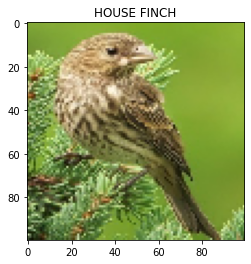

In [3]:
# use a random training image to demonstrate the augmentation techniques
def get_random_entry(dic):
    """
    Returns a random entry of a nested dictionary
    (dictionary with lists as values)
    
    Parameters:
    ----------
    dic : dictionary
        dictionary to get a random entry from
        
    Returns:
    -------
    a random entry label and a random value belonging to the entry
    """
    dic_as_list = list(dic.items())
    random_entry = random.choice(dic_as_list)
    random_label = random_entry[0]
    random_value = random.choice(random_entry[1])
    return random_label, random_value
    
sample_label, sample_image = get_random_entry(bird_dic)
fp = '{}/{}/{}'.format(data_dir_train, sample_label, sample_image)
fn = image.load_img(fp, target_size = (100,100), color_mode='rgb')
plt.imshow(fn)
plt.title(sample_label)

print(sample_image)

In [4]:
def show_transformation(original, augmented):
    """
    Compares the original with the augmented image.
    
    Parameters:
    ----------
    original : PIL.Image.Image
        image before augmentation
    augmented : PIL.Image.Image
        image after augmentation
    """
    fig = plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image before augmentation')
    plt.imshow(original)
    
    plt.subplot(1,2,2)
    plt.title('Image after augmentation')
    plt.imshow(augmented)

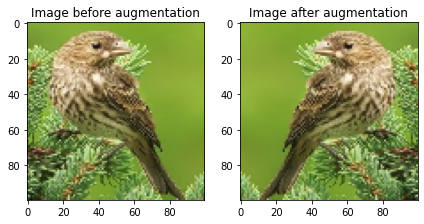

In [5]:
def horizontal_flip(image):
    """
    Randomly flips an image horizontally.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image to flip
        
    Returns:
    -------
    The flipped image
    """
    seed = (0,0)
    new = tf.image.stateless_random_flip_left_right(image, seed=seed)
    new = new.numpy()
    new = Image.fromarray(new)
    return new

h_flip = horizontal_flip(fn)
show_transformation(fn, h_flip)

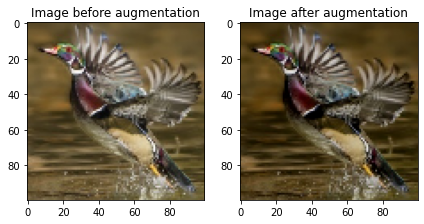

In [8]:
def change_brightness(image, max_delta=0.7):
    """
    Changes the brightness of an image by a random factor.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image to change brightness
    max_delta : float
        maximum factor by which image should be brightened/darkened
    
    Returns:
    -------
    The modified image
    """
    seed = (0,0)
    new = tf.image.stateless_random_brightness(image, max_delta = max_delta, seed = seed)
    new = new.numpy()
    new = Image.fromarray(new)
    return new
    
brightness_changed = change_brightness(fn, np.random.uniform(0,1))
show_transformation(fn, brightness_changed)

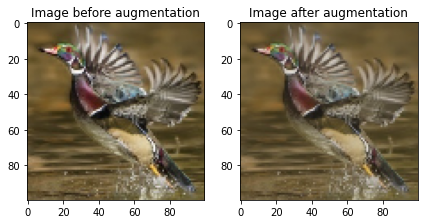

In [9]:
def change_contrast(image):
    """
    Changes the contrast of an image by a random factor.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image to change contrast
    
    Returns:
    -------
    The modified image
    """
    seed = (1,2)
    new = tf.image.stateless_random_contrast(image, lower=0.2, upper=np.random.uniform(0.2,1), seed=seed)
    new = new.numpy()
    new = Image.fromarray(new)
    return new
    
contrast_changed = change_contrast(fn)
show_transformation(fn, contrast_changed)

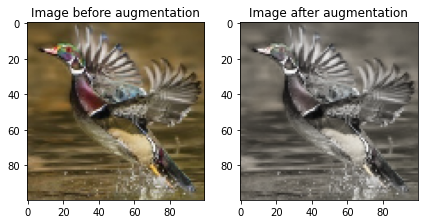

In [10]:
def change_saturation(image):
    """
    Changes the saturation of an image by a random factor.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image to change brightness
    
    Returns:
    -------
    The modified image
    """
    seed = (1,2)
    new = tf.image.stateless_random_saturation(image, lower=0.2, upper=np.random.uniform(0.2,1), seed=seed)
    new = new.numpy()
    new = Image.fromarray(new)
    return new
    
sat_changed = change_saturation(fn)
show_transformation(fn, sat_changed)

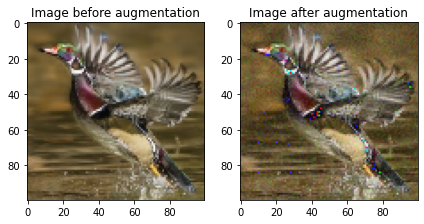

In [11]:
def gaussian_noise(image, random_chance=10):
    """
    Adds gaussian noise to an image.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image to add noise to
    
    Returns:
    -------
    The modified image
    """
    img = np.array(image)

    noise = np.random.normal(0, random_chance, img.shape)
    # noise = np.clip(noise, 0, 255)
    noise = noise.astype(np.uint8)
    img = img + noise
    img = Image.fromarray(img)
    return img

added_gaussian = gaussian_noise(fn)
show_transformation(fn, added_gaussian)

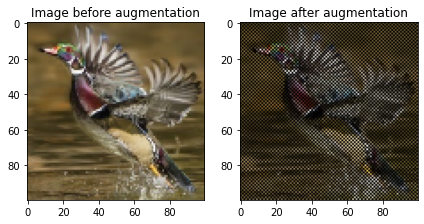

In [12]:
def grid_image(image):
    """
    Adds grid noise to an image.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image to add noise to
    
    Returns:
    -------
    The modified image
    """
    img = np.array(image)

    grid = np.zeros_like(img)
    grid[::2, ::2] = 1
    grid[1::2, 1::2] = 1
    grid = grid.astype(np.uint8)
    img = img * grid
    img = Image.fromarray(img)

    return img


added_salt_pepper = grid_image(fn)
show_transformation(fn, added_salt_pepper)


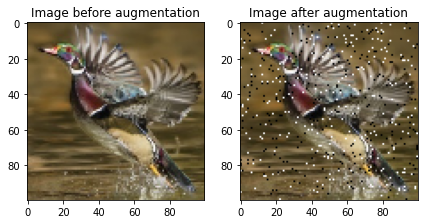

In [13]:
def salt_pepper(image):
    """
    Adds black dots to an image.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image to add noise to
    
    Returns:
    -------
    The modified image
    """
    img = np.array(image)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.random.uniform(0,1) >= 0.975:
                img[i,j] = 0
            elif np.random.uniform(0,1) <= 0.025:
                img[i,j] = 255

    img = Image.fromarray(img)
    return img


added_black_dots = salt_pepper(fn)
show_transformation(fn, added_black_dots)

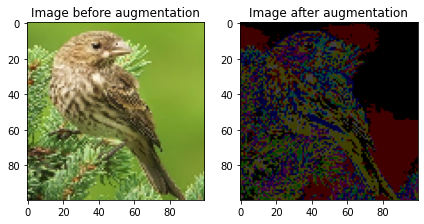

In [19]:
def bitmap_compression(image):
    """
    Compresses image by doing 6-bit shifts.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image to compress on bit level.
    
    Returns:
    -------
    The modified image
    """
    img = np.array(image)
    img_bitmap = img & (1 << 6)

    return img_bitmap


bitmap_image = bitmap_compression(fn)
show_transformation(fn, bitmap_image)

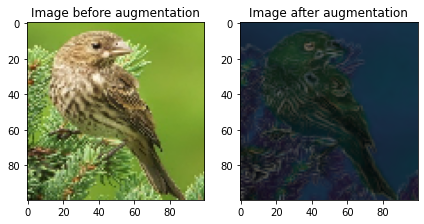

In [10]:
def edge_detection(image):
    """
    Computes gradients of pixels for edge detection using sobel filter.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image to detect edges in.
    
    Returns:
    -------
    The modified image
    """
    img = np.array(image)
    img_grad = filters.sobel(img)

    return img_grad


grad_image = edge_detection(fn)
show_transformation(fn, grad_image)

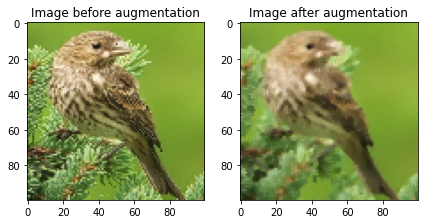

In [7]:
def median_blur(image):
    """
    Smoothens the image with median blur.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image on which to apply median smoothing
    
    Returns:
    -------
    The modified image
    """
    img = np.array(image)
    img_blurred = medianBlur(img, 3)

    return img_blurred


median_blurred_image = median_blur(fn)
show_transformation(fn, median_blurred_image)

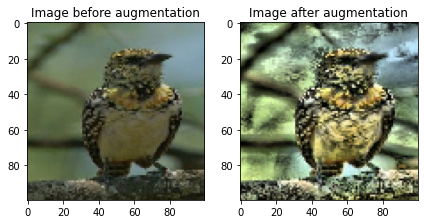

In [41]:
def ahe(image):
    """
    Execute Adaptive Histogram Equilisation (AHE) on input image.
    
    Parameters:
    ----------
    image : PIL.Image.Image
        image of which to equilise histrogram / increase entropy
    
    Returns:
    -------
    The modified image
    """
    img = np.array(image)
    img_ahe = exposure.equalize_adapthist(img, clip_limit = 1)

    return img_ahe


ahe_on = ahe(fn)
show_transformation(fn, ahe_on)

##### Save images

In [14]:
for key, value in bird_dic.items():
    print(key,':', len(value))

CASPIAN TERN : 100
D-ARNAUDS BARBET : 100
DARK EYED JUNCO : 100
HOUSE FINCH : 100
OVENBIRD : 100
OYSTER CATCHER : 100
RED TAILED HAWK : 100
SWINHOES PHEASANT : 100
VIOLET GREEN SWALLOW : 100
WOOD DUCK : 100


In [15]:
# prepare a folder for the augmented images

if os.path.exists('../Data/Use/Preprocessed/Augmented/..'):
    os.removedirs('../Data/Use/Preprocessed/Augmented')

os.mkdir('../Data/Use/Preprocessed')
os.mkdir('../Data/Use/Preprocessed/Augmented')


def save_img(dict):
    """
    Creates a folder and saves the augmented images of each class.
    
    Parameters:
    ----------
    dict : dictionary
        dictionary with the mean image for all classes
    """
    augmentation_techniques = [horizontal_flip, change_brightness, change_contrast, change_saturation, gaussian_noise, grid_image, salt_pepper]

    for key, value in dict.items():
        os.mkdir('../Data/Use/Preprocessed/Augmented/' + key)
        for img in value:

            fp = '{}/{}/{}'.format(data_dir_train, key, img)
            fn = image.load_img(fp, target_size = (100,100), color_mode='rgb')

            augmented_image = np.random.choice(augmentation_techniques)(fn)

            name = img.strip('.jpg')

            fn.save(f'../Data/Use/Preprocessed/Augmented/{key}/{name}.jpg')
            augmented_image.save(f'../Data/Use/Preprocessed/Augmented/{key}/{name}_augmented.jpg')


save_img(bird_dic)

OSError: [WinError 145] The directory is not empty: '../Data/Use/Preprocessed/Augmented'